<a href="https://colab.research.google.com/github/dbamman/nlp22/blob/master/AP/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BERT for binary or multiclass document classification using the [CLS] token as the document representation; trains a model (on `train.txt`), uses `dev.txt` for early stopping, and evaluates performance on `test.txt`.  Reports test accuracy with 95% confidence intervals.

Before executing this notebook on Colab, make sure you're running on cuda (`Runtime > Change runtime type > GPU`) to make use of GPU speedups.

In [1]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 4.3 MB/s 
     |████████████████████████████████| 77 kB 6.7 MB/s 
     |████████████████████████████████| 596 kB 49.1 MB/s 
     |████████████████████████████████| 895 kB 38.2 MB/s 
     |████████████████████████████████| 6.6 MB 37.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
from transformers import BertModel, BertTokenizer
import nltk
import torch
import torch.nn as nn
import numpy as np
import random
from scipy.stats import norm
import math

In [3]:
# If you have your folder of data on your Google drive account, you can connect that here
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
# Change this to the directory with your data
#directory="/drive/MyDrive/ap_data/56"
directory="/content/drive/MyDrive/ap_data/56"
#import os
#os.chdir('56')
#print(os.listdir())
#print(os.getcwd())

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on {}".format(device))

Running on cuda


In [6]:
def read_labels(filename):
    labels={}
    with open(filename) as file:
        for line in file:
            cols = line.split("\t")
            label = cols[1]
            if label not in labels:
                labels[label]=len(labels)
    return labels

In [7]:
def read_data(filename, labels, max_data_points=1000):
  
    data = []
    data_labels = []
    with open(filename) as file:
        for line in file:
            cols = line.split("\t")
            label = cols[1]
            text = cols[2]
            
            data.append(text)
            data_labels.append(labels[label])
            

    # shuffle the data
    tmp = list(zip(data, data_labels))
    random.shuffle(tmp)
    data, data_labels = zip(*tmp)
    
    if max_data_points is None:
        return data, data_labels
    
    return data[:max_data_points], data_labels[:max_data_points]

In [8]:
labels=read_labels("%s/train.txt" % directory)

In [9]:
train_x, train_y=read_data("%s/train.txt" % directory, labels, max_data_points=None)

In [10]:
dev_x, dev_y=read_data("%s/dev.txt" % directory, labels, max_data_points=None)

In [11]:
test_x, test_y=read_data("%s/test.txt" % directory, labels, max_data_points=None)

In [12]:
def evaluate(model, x, y):
    model.eval()
    corr = 0.
    total = 0.
    with torch.no_grad():
        for x, y in zip(x, y):
            y_preds=model.forward(x)
            for idx, y_pred in enumerate(y_preds):
                prediction=torch.argmax(y_pred)
                if prediction == y[idx]:
                    corr += 1.
                total+=1                          
    return corr/total, total

In [13]:
class BERTClassifier(nn.Module):

    def __init__(self, bert_model_name, params):
        super().__init__()
    
        self.model_name=bert_model_name
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name, do_lower_case=params["doLowerCase"], do_basic_tokenize=False)
        self.bert = BertModel.from_pretrained(self.model_name)
        
        self.num_labels = params["label_length"]

        self.fc = nn.Linear(params["embedding_size"], self.num_labels)

    def get_batches(self, all_x, all_y, batch_size=2, max_toks=510):
            
        """ Get batches for input x, y data, with data tokenized according to the BERT tokenizer 
      (and limited to a maximum number of WordPiece tokens """

        batches_x=[]
        batches_y=[]
        
        for i in range(0, len(all_x), batch_size):

            current_batch=[]

            x=all_x[i:i+batch_size]

            batch_x = self.tokenizer(x, padding=True, truncation=True, return_tensors="pt", max_length=max_toks)
            batch_y=all_y[i:i+batch_size]

            batches_x.append(batch_x.to(device))
            batches_y.append(torch.LongTensor(batch_y).to(device))
            
        return batches_x, batches_y
  

    def forward(self, batch_x): 
    
        bert_output = self.bert(input_ids=batch_x["input_ids"],
                         attention_mask=batch_x["attention_mask"],
                         token_type_ids=batch_x["token_type_ids"],
                         output_hidden_states=True)

      # We're going to represent an entire document just by its [CLS] embedding (at position 0)
      # And use the *last* layer output (layer -1)
      # as a result of this choice, this embedding will be optimized for this purpose during the training process.
      
        bert_hidden_states = bert_output['hidden_states']

        out = bert_hidden_states[-1][:,0,:]

        out = self.fc(out)

        return out.squeeze()

In [14]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [15]:
def train(bert_model_name, model_filename, train_x, train_y, dev_x, dev_y, labels, embedding_size=768, doLowerCase=None):

    bert_model = BERTClassifier(bert_model_name, params={"label_length": len(labels), "doLowerCase":doLowerCase, "embedding_size":embedding_size})
    bert_model.to(device)

    batch_x, batch_y = bert_model.get_batches(train_x, train_y)
    dev_batch_x, dev_batch_y = bert_model.get_batches(dev_x, dev_y)

    optimizer = torch.optim.Adam(bert_model.parameters(), lr=1e-5)
    cross_entropy=nn.CrossEntropyLoss()

    num_epochs=30
    best_dev_acc = 0.
    patience=5

    best_epoch=0

    for epoch in range(num_epochs):
        bert_model.train()

        # Train
        for x, y in zip(batch_x, batch_y):
            y_pred = bert_model.forward(x)
            loss = cross_entropy(y_pred.view(-1, bert_model.num_labels), y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluate
        dev_accuracy, _=evaluate(bert_model, dev_batch_x, dev_batch_y)
        if epoch % 1 == 0:
            print("Epoch %s, dev accuracy: %.3f" % (epoch, dev_accuracy))
            if dev_accuracy > best_dev_acc:
                torch.save(bert_model.state_dict(), model_filename)
                best_dev_acc = dev_accuracy
                best_epoch=epoch
        if epoch - best_epoch > patience:
            print("No improvement in dev accuracy over %s epochs; stopping training" % patience)
            break

    bert_model.load_state_dict(torch.load(model_filename))
    print("\nBest Performing Model achieves dev accuracy of : %.3f" % (best_dev_acc))
    return bert_model


In [16]:
# small BERT -- can run on laptop
# bert_model_name="google/bert_uncased_L-2_H-128_A-2"
# model_filename="mybert.model"
# embedding_size=128
# doLowerCase=True

# bert-base -- slow on laptop; better on Colab
bert_model_name="bert-base-cased"
#bert_model_name="bert-large-cased"
model_filename="mybert.model"
embedding_size=768
doLowerCase=False

model=train(bert_model_name, model_filename, train_x, train_y, dev_x, dev_y, labels, embedding_size=embedding_size, doLowerCase=doLowerCase)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 0, dev accuracy: 0.680
Epoch 1, dev accuracy: 0.685
Epoch 2, dev accuracy: 0.705
Epoch 3, dev accuracy: 0.720
Epoch 4, dev accuracy: 0.735
Epoch 5, dev accuracy: 0.770
Epoch 6, dev accuracy: 0.740
Epoch 7, dev accuracy: 0.755
Epoch 8, dev accuracy: 0.715
Epoch 9, dev accuracy: 0.735
Epoch 10, dev accuracy: 0.740
Epoch 11, dev accuracy: 0.765
No improvement in dev accuracy over 5 epochs; stopping training

Best Performing Model achieves dev accuracy of : 0.770


In [19]:
test_batch_x, test_batch_y = model.get_batches(test_x, test_y)
accuracy, test_n=evaluate(model, test_batch_x, test_batch_y)

lower, upper=confidence_intervals(accuracy, test_n, .95)
print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

Test accuracy for best dev model: 0.718, 95% CIs: [0.656 0.780]



202
202


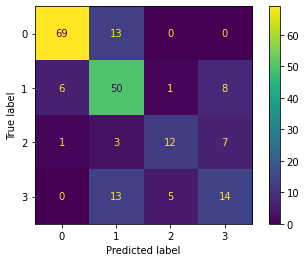

In [20]:
def get_preds(model, x, y):
    model.eval()
    preds = []
    with torch.no_grad():
        for x, y in zip(x, y):
            y_preds=model.forward(x)
            for idx, y_pred in enumerate(y_preds):
                prediction=torch.argmax(y_pred).cpu().detach().numpy()
                preds.append(prediction)                        
    return preds

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

#test_batch_x, test_batch_y
preds = get_preds(model, test_batch_x, test_batch_y)
print(len(test_y))
print(len(preds))
cm = confusion_matrix(test_y, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()